# ML AS 1 



In [22]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import sklearn
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader

ModuleNotFoundError: No module named 'sklearn'

In [4]:
class MNIST_Dataset(Dataset): 
    def __init__(self,filename): 
        self.data = torch.load(filename)[0]
        self.labels = torch.load(filename)[1]
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, index):
        return self.data[index], self.labels[index]

In [5]:
def train(loader, model, loss_func, optimizer):
    size = len(loader.dataset)
    for batch, (X, y) in enumerate(loader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(loader, model):
    size = len(loader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
batch_size = 64
mnist_real_train = MNIST_Dataset("MNIST/processed/training.pt")

mnist_train, mnist_validation = data.random_split(mnist_real_train, (48000, 12000))


train_dataloader = DataLoader(mnist_train, batch_size=batch_size)
validation_dataloader = DataLoader(mnist_validation, batch_size=batch_size)

mnist_test = MNIST_Dataset("MNIST/processed/test.pt")
test_dataloader = DataLoader(mnist_test, batch_size=batch_size)
# train()
len(mnist_real_train), len(mnist_train), len(mnist_validation), len(mnist_test)

(60000, 48000, 12000, 10000)

In [15]:
#taken from lady
def compute_acc(logits, expected):
    pred = logits.argmax(dim=1)
    return (pred == expected).type(torch.float).mean()

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)
Epoch 1
-------------------------------
loss: 10.468575  [    0/48000]
loss: 1.807958  [ 6400/48000]
loss: 1.852179  [12800/48000]
loss: 1.553096  [19200/48000]
loss: 1.878364  [25600/48000]
loss: 1.816869  [32000/48000]
loss: 2.016561  [38400/48000]
loss: 1.907539  [44800/48000]
Test Error: 
 Accuracy: 30.2%, Avg loss: 0.029126 

Epoch 2
-------------------------------
loss: 1.942828  [    0/48000]
loss: 1.767803  [ 6400/48000]
loss: 1.836094  [12800/48000]
loss: 1.550366  [19200/48000]
loss: 1.871693  [25600/48000]
loss: 1.813582  [32000/48000]
loss: 1.993218  [38400/48000]
loss: 1.860919  [44800/48000]
Test Error: 
 Accuracy: 30.5%, Avg 

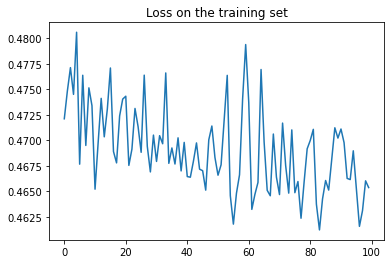

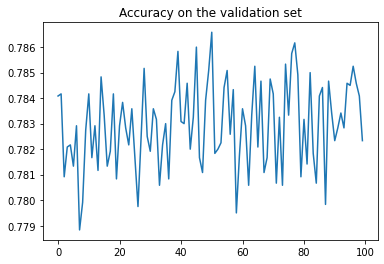

In [18]:
opt = optim.Adam(model.parameters())
cost = torch.nn.CrossEntropyLoss()

loss_values = []
acc_values = []
batch_size = 128
n_epoch = 100

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)

plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

# print(loss_values)
# print(acc_values)

In [20]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, ConcatDataset

ModuleNotFoundError: No module named 'sklearn'

In [19]:
# Configuration parameters for k-fold evaluation 
k_folds = 5
num_epochs = 1
loss_function = nn.CrossEntropyLoss()

# Array for fold results 
results = {}

# Set fixed random number seed
torch.manual_seed(42)

#concated dataset for 
dataset = ConcatDataset([mnist_train, mnist_test, mnist_validation])

NameError: name 'ConcatDataset' is not defined

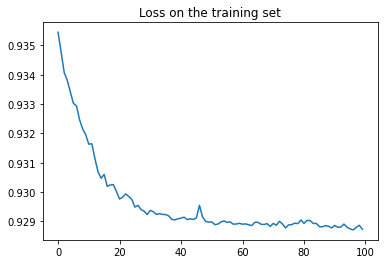

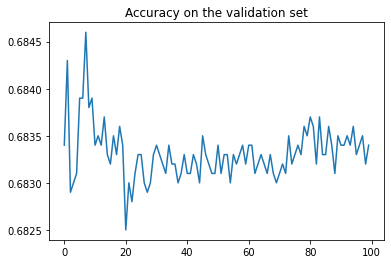

[tensor(0.9354), tensor(0.9348), tensor(0.9341), tensor(0.9338), tensor(0.9334), tensor(0.9330), tensor(0.9329), tensor(0.9325), tensor(0.9322), tensor(0.9320), tensor(0.9316), tensor(0.9316), tensor(0.9311), tensor(0.9307), tensor(0.9305), tensor(0.9306), tensor(0.9302), tensor(0.9302), tensor(0.9303), tensor(0.9300), tensor(0.9298), tensor(0.9298), tensor(0.9299), tensor(0.9299), tensor(0.9298), tensor(0.9295), tensor(0.9296), tensor(0.9294), tensor(0.9293), tensor(0.9292), tensor(0.9294), tensor(0.9293), tensor(0.9292), tensor(0.9293), tensor(0.9292), tensor(0.9292), tensor(0.9292), tensor(0.9291), tensor(0.9291), tensor(0.9291), tensor(0.9291), tensor(0.9291), tensor(0.9291), tensor(0.9291), tensor(0.9291), tensor(0.9291), tensor(0.9295), tensor(0.9292), tensor(0.9290), tensor(0.9290), tensor(0.9290), tensor(0.9289), tensor(0.9289), tensor(0.9290), tensor(0.9290), tensor(0.9290), tensor(0.9290), tensor(0.9289), tensor(0.9289), tensor(0.9289), tensor(0.9289), tensor(0.9289), tensor(

In [53]:
opt = optim.SGD(model.parameters(),.01)
cost = torch.nn.CrossEntropyLoss()

loss_values = []
acc_values = []
batch_size = 128
n_epoch = 100

for epoch in range(n_epoch):
    model.train()
    loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    epoch_loss = []
    for X_batch, y_batch in loader:
        opt.zero_grad()
        logits = model(X_batch.float())
        loss = cost(logits, y_batch)
        loss.backward()
        opt.step()        
        epoch_loss.append(loss.detach())
    loss_values.append(torch.tensor(epoch_loss).mean())
    model.eval()
    loader = data.DataLoader(mnist_validation, batch_size=len(mnist_validation), shuffle=False)
    X, y = next(iter(loader))
    logits = model(X.float())
    acc = compute_acc(logits, y)
    acc_values.append(acc)

plt.title("Loss on the training set")
plt.plot(loss_values)
plt.show()
plt.title("Accuracy on the validation set")
plt.plot(acc_values)
plt.show()

print(loss_values)
print(acc_values)